**[Sumber Data Capital Bike Share](http://capitalbikeshare.com/system-data)** 

### **Contents**

1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

****

## **Business Problem Understanding**

**Context**

Bikesharing adalah sistem peminjaman sepeda yang sedang populer di beberapa kota metropolitan diseluruh dunia. Banyak pelanggan, menggunakan sistem *bikeshare* tersebut untuk berbagai macam kebutuhan mulai dari sebagai hiburan atau bersosialisasi, pergi ke tempat wisata, dan tentunya untuk pergi bekerja. Alasan utama pelanggan menggunakan layanan *bikeshare* adalah untuk menghindari kemacetan, alasan kesehatan dan juga harga yang murah.

Oleh karena itu, dari data yang tersedia kita mencoba untuk mengetahui jumlah *demand* yang dibutuhkan untuk memenuhi kebutuhan dari pengguna layanan. Hal-hal apa saja yang mempengaruhi pelanggan untuk menggunakan jasa dari sistem bikeshare ini kita akan coba analisa dengan menggunakan *Supervised Machine learning - Regression*. 

**Problem Statement**

Salah satu masalah yang dimiliki oleh sistem *bikesharing* ini adalah menentukan jumlah armada yang dibutuhkan untuk memenuhi *demand* dari calon pengguna jasa.

Kemampuan untuk memprediksi jumlah armada yang dibutuhkan dalam suatu waktu tertentu menjadi keuntungan bagi pemiliki usaha.

**Goals**

Tujuan dari pembuatan *Machine learning* ini adalah untuk membantu perusahaan *bike sharing* dalam menentukan jumlah armada yang dibutuhkan dalam suatu waktu dan kondisi tertentu. Hasil dari *machine learning* ini nantinya bisa menjadi alat untuk membantu pemilik usaha dalam mengambil keputusan.

**Analytic Approach**

Dengan fitur - fitur yang sudah dikumpulkan kita akan membangun alat *demand predictor*. Dengan menggunakan model-model regresi yang ada kita akan memilih model terbaik menggunakan Gridsearch dan RandomSearch. Dan melakukan Hyperparameter Tuning terhadap model yang memiliki peforma terbaik.

Untuk evaluasi metrik yang akan digunakan RMSE, MAE, dan MAPE. Untuk final evaluation metrics akan dipilih setelah dilakukan analisa dan pemodelan.

## **Data Understanding**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#Data Preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Import library untuk modeling

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from scipy.special import boxcox, inv_boxcox

In [3]:
df = pd.read_csv(r'D:\Dokumen\Kerja\Visual Code\File Capstone 3\data_bike_sharing.csv')
df.head()

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857


**Given Features**

* dteday: date
* season: season (1: winter, 2: spring, 3: summer, 4: fall)
* hr: hour (0 to 23)
* holiday: holiday or not
* temp: normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (only in hourly scale)
* hum: normalized humidity. The values are divided into 100 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered
* weathersit:   
    1: Clear, Few clouds, Partly cloudy, Partly cloudy  
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist     
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atemp       12165 non-null  float64
 6   temp        12165 non-null  float64
 7   hr          12165 non-null  int64  
 8   casual      12165 non-null  int64  
 9   registered  12165 non-null  int64  
 10  cnt         12165 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


In [5]:
# Check data duplicate

print(df.duplicated().sum())
print('Tidak ada data duplikat')

0
Tidak ada data duplikat


In [6]:
# Check missing values

print(df.isna().sum().sum())
print('Tidak ada missing values')

0
Tidak ada missing values


In [7]:
# Check registered + casual = total count

df['casual'].sum() + df['registered'].sum() - df['cnt'].sum()

0

In [8]:
df.describe()

,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
count,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,0.625451,1.416934,0.029758,2.488615,0.476996,0.498185,11.519770,35.834443,153.436580,189.271023
std,0.192102,0.635937,0.169925,1.106157,0.171857,0.192492,6.931872,49.489286,151.046123,181.223903
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.470000,1.000000,0.000000,2.000000,0.333300,0.340000,6.000000,4.000000,34.000000,40.000000
50%,0.620000,1.000000,0.000000,2.000000,0.484800,0.500000,12.000000,17.000000,115.000000,142.000000
75%,0.780000,2.000000,0.000000,3.000000,0.621200,0.660000,18.000000,49.000000,220.000000,282.000000
max,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,23.000000,362.000000,876.000000,970.000000


In [9]:
# Check unique value

cat_variable = df.select_dtypes(include='object')

columns = df.columns
unique_value = [df[x].dropna().unique() for x in df.columns]
total_unique_value = [df[x].dropna().nunique() for x in df.columns]

summary = pd.DataFrame({
    'name': columns,
    'Total Unique Value': total_unique_value,
    'Unique Value': unique_value 
})

summary

,name,Total Unique Value,Unique Value
0,dteday,731,"[2011-12-09, 2012-06-17, 2011-06-15, 2012-03-3..."
1,hum,89,"[0.62, 0.64, 0.53, 0.87, 0.55, 0.72, 0.54, 0.9..."
2,weathersit,4,"[1, 2, 3, 4]"
3,holiday,2,"[0, 1]"
4,season,4,"[4, 2, 3, 1]"
5,atemp,65,"[0.3485, 0.5152, 0.6212, 0.697, 0.4545, 0.6515..."
6,temp,50,"[0.36, 0.54, 0.62, 0.76, 0.46, 0.7, 0.26, 0.82..."
7,hr,24,"[16, 4, 23, 8, 18, 0, 22, 9, 5, 7, 14, 15, 21,..."
8,casual,305,"[24, 2, 17, 19, 99, 6, 20, 13, 219, 1, 11, 9, ..."
9,registered,742,"[226, 16, 90, 126, 758, 39, 196, 27, 5, 315, 2..."


**Add New Feature**

In [10]:
# Extract Feature from dteday

df['dteday'] = pd.to_datetime(df['dteday'])

# Add Month Feature
df['month'] = df['dteday'].dt.month

# Add Day Feature
df['day'] = df['dteday'].dt.day_of_week

# Add Weekend Feature
df['weekend'] = np.where(df['day']> 4, 1,0)

# Drop dteday columns
df.drop(labels='dteday', axis=1, inplace=True)

In [11]:
# Extract feature from Hour

def timeofdays(x):
    if (x >= 5) and (x <= 12):
        return 1 #morning
    elif (x >= 13) and (x <= 17 ):
        return 2 #afternoon
    elif (x >= 18) and (x <= 21):
        return 3 #evening
    else:
        return 4 #night
    
timeofday = []

for i in df['hr']:
    time = timeofdays(i)
    timeofday.append(time)

df['timeofday'] = timeofday 

In [12]:
df.head()

,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt,month,day,weekend,timeofday
0,0.62,1,0,4,0.3485,0.36,16,24,226,250,12,4,0,2
1,0.64,1,0,2,0.5152,0.54,4,2,16,18,6,6,1,4
2,0.53,1,0,2,0.6212,0.62,23,17,90,107,6,2,0,4
3,0.87,2,0,2,0.3485,0.36,8,19,126,145,3,5,1,1
4,0.55,1,0,3,0.6970,0.76,18,99,758,857,7,1,0,3


## **EDA**

In [13]:
df.describe()

,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt,month,day,weekend,timeofday
count,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,0.625451,1.416934,0.029758,2.488615,0.476996,0.498185,11.519770,35.834443,153.436580,189.271023,6.510974,3.005261,0.285984,2.411837
std,0.192102,0.635937,0.169925,1.106157,0.171857,0.192492,6.931872,49.489286,151.046123,181.223903,3.433995,1.992993,0.451901,1.221879
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,0.470000,1.000000,0.000000,2.000000,0.333300,0.340000,6.000000,4.000000,34.000000,40.000000,4.000000,1.000000,0.000000,1.000000
50%,0.620000,1.000000,0.000000,2.000000,0.484800,0.500000,12.000000,17.000000,115.000000,142.000000,7.000000,3.000000,0.000000,2.000000
75%,0.780000,2.000000,0.000000,3.000000,0.621200,0.660000,18.000000,49.000000,220.000000,282.000000,9.000000,5.000000,1.000000,4.000000
max,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,23.000000,362.000000,876.000000,970.000000,12.000000,6.000000,1.000000,4.000000


**Distribution**

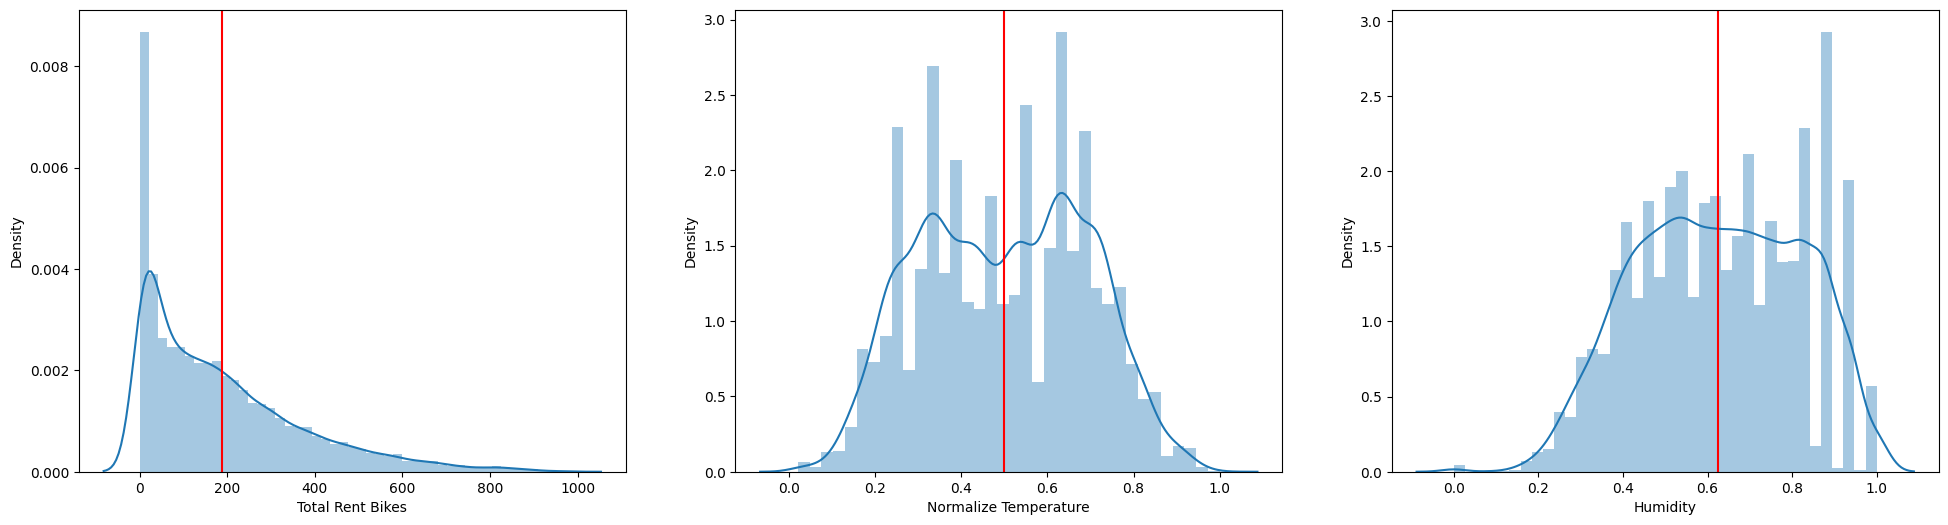

In [14]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))
sns.distplot(df['cnt'], kde=True,ax=axes[0])
sns.distplot(df['temp'], kde=True,ax=axes[1])
sns.distplot(df['hum'], kde=True,ax=axes[2])

axes[0].set_xlabel('Total Rent Bikes')
axes[1].set_xlabel('Normalize Temperature')
axes[2].set_xlabel('Humidity')

axes[0].axvline(x=df.cnt.mean(), color='r')
axes[1].axvline(x=df.temp.mean(), color='r')
axes[2].axvline(x=df.hum.mean(), color='r')

plt.show()

* Berdasarkan grafik plot diatas jumlah rental sepeda memiliki *right-skewed distribution*.
* Sedangkan untuk normalize temperature memiliki *bimodal distribution*, tetapi dengan nilai mean (0.498) dan median (0.500) yang berdekatan kita bisa asumsikan *temp* memiliki normal distribution.
* Dan untuk humidity memiliki bentuk mirip dengan *bell-shape* juga dengan nilai median (0.620) dan mean (0.625) yang tidak jauh berbeda, kita bisa asumsikan *hum* berdistribusi normal.

**Outlier**

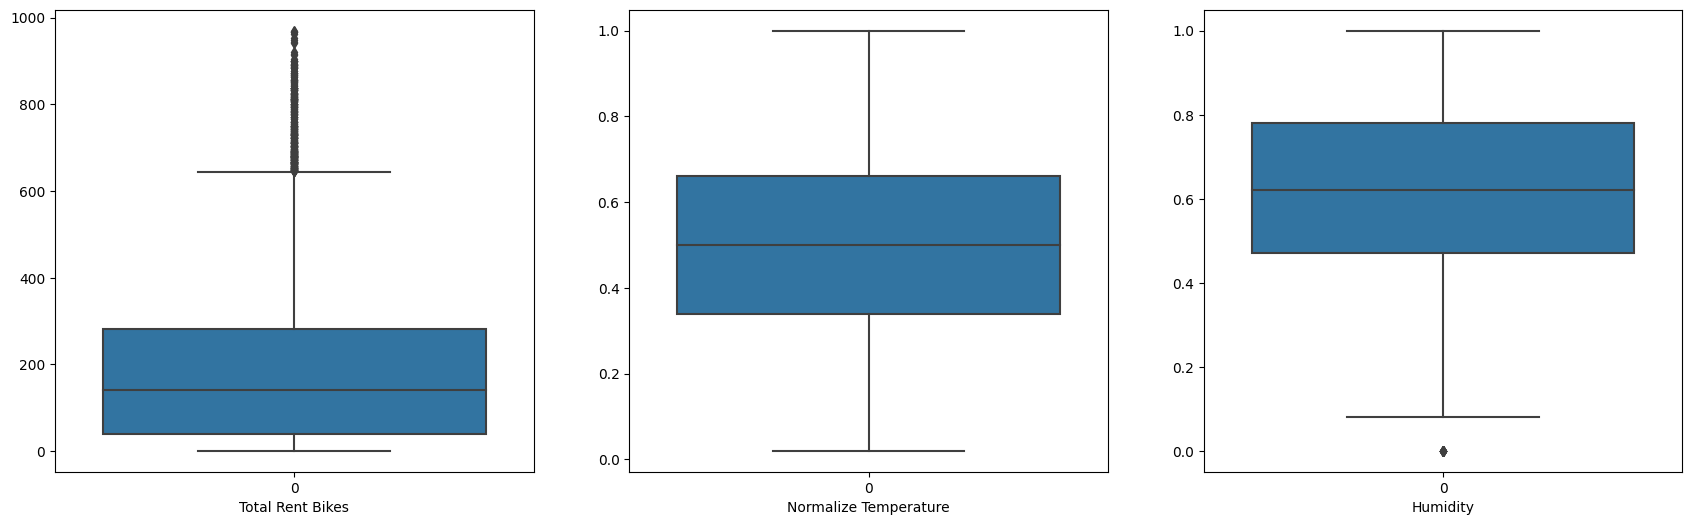

In [15]:
fig, axes = plt.subplots(1,3, figsize=(21, 6))
sns.boxplot(df['cnt'], ax=axes[0])
sns.boxplot(df['temp'],ax=axes[1])
sns.boxplot(df['hum'], ax=axes[2])

axes[0].set_xlabel('Total Rent Bikes')
axes[1].set_xlabel('Normalize Temperature')
axes[2].set_xlabel('Humidity')

plt.show()

* Berdasarkan grafik plot data diatas jumlah rental sepeda memiliki outliers yang cukup banyak.
* Sedangkan *normalize temperature* tidak memiliki outlier sama sekali.
* Dan untuk *humidity* memiliki beberapa outlier.

**Correlation**

Text(0.5, 1.0, 'Correlation Matrix')

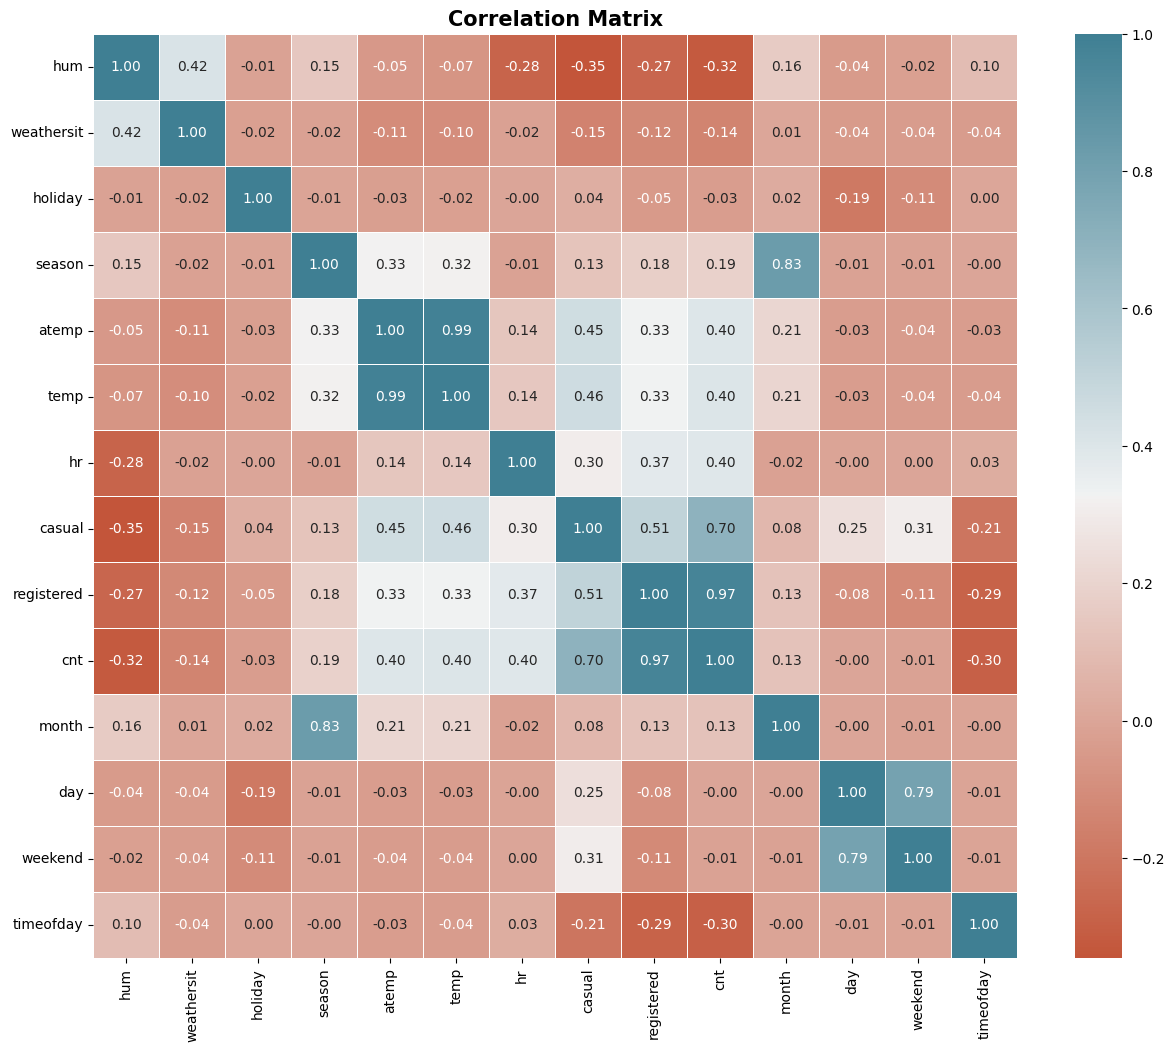

In [16]:
# Correlation matrix
plt.figure(figsize=(15, 12))
palette=sns.diverging_palette(20, 220, n=256)
corr = df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Correlation Matrix', size=15, weight='bold')

* Berdasarkan *correlation matrix* diatas beberapa feature memiliki korelasi yang cukup tinggi, sehingga multikolinearitas mungkin saja terjadi.
* Contohnya, antara *cnt* dengan *casual* dan *registered* memiliki korelasi yang cukup tinggi karena *cnt* adalah jumlah dari kedua feature tersebut.
* Kemudian feature *temp* dan *atemp* memiliki korelasi yang cukup tinggi, karena nilai *atemp* didapat dari *temp* itu sendiri.
* Dan terakhir antara *day* dan *weekend* serta *season* dan *month* memiliki korelasi yang cukup tinggi.

Oleh karena itu, untuk menghindari multikolinearitas kita akan menghapus beberapa fitur yang memiliki korelasi yang tinggi.

In [17]:
df_model = df.drop(labels=['atemp', 'casual', 'registered', 'month', 'weekend'], axis=1)
df_model.head()

,hum,weathersit,holiday,season,temp,hr,cnt,day,timeofday
0,0.62,1,0,4,0.36,16,250,4,2
1,0.64,1,0,2,0.54,4,18,6,4
2,0.53,1,0,2,0.62,23,107,2,4
3,0.87,2,0,2,0.36,8,145,5,1
4,0.55,1,0,3,0.76,18,857,1,3


**Features for modeling**

* season: season (1: winter, 2: spring, 3: summer, 4: fall)
* hr: hour (0 to 23)
* holiday: holiday or not
* temp: normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)
* hum: normalized humidity. The values are divided into 100 (max)
* cnt: count of total rental bikes including both casual and registered
* weathersit:   
    1: Clear, Few clouds, Partly cloudy, Partly cloudy  
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist     
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* day: Monday to Sunday
* timeofday:    
    1: Morning (5 am - 12 pm)   
    2: Afternoon (13 pm - 17 pm)     
    3: Evening  (18 pm - 21 pm)     
    4: Night (22 pm - 4 am)

## **Data Preprocessing**

Dari eksplorasi data diatas kita bisa lihat bahwa distribusi dari target tidak mendekati normal distribution. Oleh karena itu untuk membuat supaya target lebih mendekati normal distribution ada dua cara yang akan digunakan yaitu:
* Pertama dengan menghilangkan nilai outlier di dependent variables
* Kedua dengan melakukan *BoxCox* transformation terhadap dependent variables

### **Drop Outlier In Dependent Variables**

In [18]:
df_model.cnt.describe()

count    12165.000000
mean       189.271023
std        181.223903
min          1.000000
25%         40.000000
50%        142.000000
75%        282.000000
max        970.000000
Name: cnt, dtype: float64

In [19]:
Q1 = df_model['cnt'].describe()['25%']
Q3 = df_model['cnt'].describe()['75%']
IQR = Q3 - Q1

upper_lim = Q3 + (IQR*1.5)
lower_lim = Q1 - (IQR*1.5) 

print(f'Dependant Variables Q1 = {Q1}')
print(f'Dependant Variables Q3 = {Q3}')
print(f'Dependant Variables IQR = {IQR}')
print(f'Dependant Variables Upper Limit = {upper_lim}')
print(f'Dependant Variables Lower Limit = {lower_lim}')

Dependant Variables Q1 = 40.0
Dependant Variables Q3 = 282.0
Dependant Variables IQR = 242.0
Dependant Variables Upper Limit = 645.0
Dependant Variables Lower Limit = -323.0


In [20]:
sum_outlier = df_model[df_model['cnt'] > upper_lim].count()['cnt']

print(f'Jumlah data outlier adalah {sum_outlier}.')

Jumlah data outlier adalah 338.


In [21]:
# Data Frame baru untuk data yang tanpa outlier
df_no_outlier = df_model[df_model['cnt'] <= upper_lim]

df_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11827 entries, 0 to 12164
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hum         11827 non-null  float64
 1   weathersit  11827 non-null  int64  
 2   holiday     11827 non-null  int64  
 3   season      11827 non-null  int64  
 4   temp        11827 non-null  float64
 5   hr          11827 non-null  int64  
 6   cnt         11827 non-null  int64  
 7   day         11827 non-null  int64  
 8   timeofday   11827 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 924.0 KB


In [22]:
df_no_outlier.describe()

,hum,weathersit,holiday,season,temp,hr,cnt,day,timeofday
count,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000
mean,0.628451,1.422508,0.030523,2.476283,0.494223,11.438573,173.211634,3.014966,2.424368
std,0.191904,0.639458,0.172030,1.109973,0.192464,6.978877,155.922696,1.998273,1.230328
min,0.000000,1.000000,0.000000,1.000000,0.020000,0.000000,1.000000,0.000000,1.000000
25%,0.480000,1.000000,0.000000,1.000000,0.340000,5.000000,37.000000,1.000000,1.000000
50%,0.630000,1.000000,0.000000,2.000000,0.500000,11.000000,136.000000,3.000000,2.000000
75%,0.790000,2.000000,0.000000,3.000000,0.660000,18.000000,267.000000,5.000000,4.000000
max,1.000000,4.000000,1.000000,4.000000,1.000000,23.000000,645.000000,6.000000,4.000000


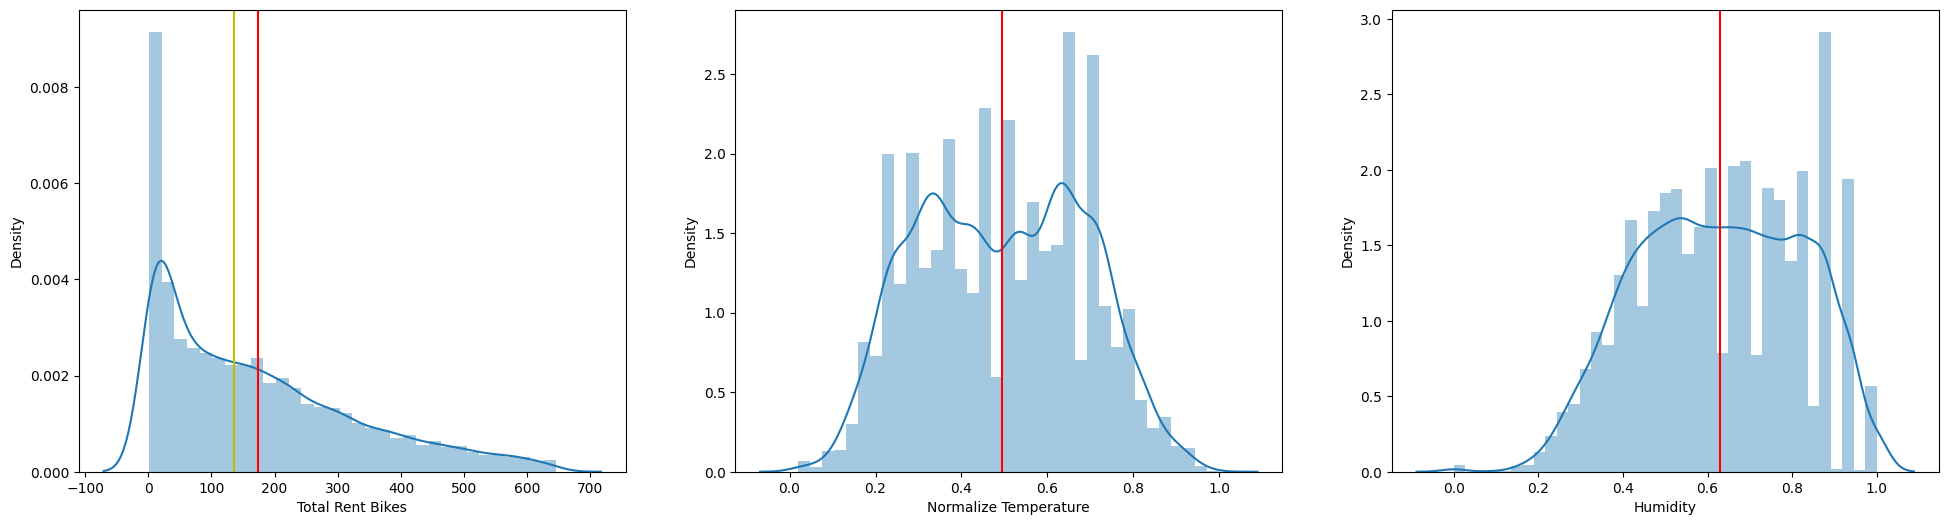

In [23]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))
sns.distplot(df_no_outlier['cnt'], kde=True,ax=axes[0])
sns.distplot(df_no_outlier['temp'], kde=True,ax=axes[1])
sns.distplot(df_no_outlier['hum'], kde=True,ax=axes[2])

axes[0].set_xlabel('Total Rent Bikes')
axes[1].set_xlabel('Normalize Temperature')
axes[2].set_xlabel('Humidity')

axes[0].axvline(x=df_no_outlier.cnt.mean(), color='r')
axes[0].axvline(x=df_no_outlier.cnt.median(), color='y')
axes[1].axvline(x=df_no_outlier.temp.mean(), color='r')
axes[2].axvline(x=df_no_outlier.hum.mean(), color='r')

plt.show()

* Berdasarkan grafik plot diatas, setelah outlier dihilangkan dari dataset distribusi dari dependendant variable (Total Rent Bikes) masih memiliki *right-skewed distribution*.
* Oleh karena itu, hanya menghilangkan outlier saja belum cukup agar dependant variable mendekati distribusi normal.

### **Using BoxCox Transformation On Dependent Variables**

In [24]:
bcx, lam = stats.boxcox(df_no_outlier.cnt)

In [25]:
print(f'Nilai Mean Setelah BoxCox Transformation, {np.mean(bcx)}')
print(f'Nilai Median Setelah BoxCox Transformation,{np.median(bcx)}')

Nilai Mean Setelah BoxCox Transformation, 11.762762764435376
Nilai Median Setelah BoxCox Transformation,12.436313268711942


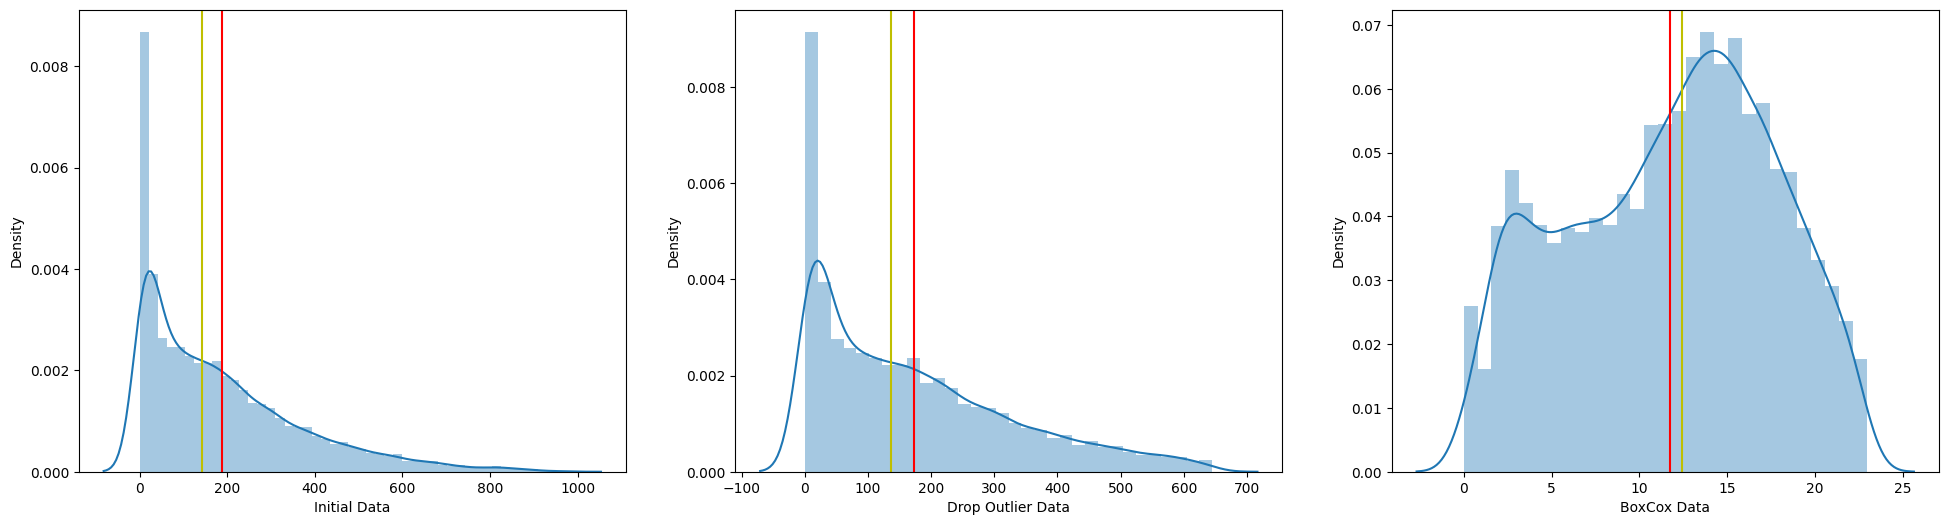

In [26]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))
sns.distplot(df['cnt'], kde=True,ax=axes[0])
sns.distplot(df_no_outlier['cnt'], kde=True,ax=axes[1])
sns.distplot(bcx, kde=True,ax=axes[2])

axes[0].set_xlabel('Initial Data')
axes[1].set_xlabel('Drop Outlier Data')
axes[2].set_xlabel('BoxCox Data')

axes[0].axvline(x=df.cnt.mean(), color='r')
axes[0].axvline(x=df.cnt.median(), color='y')
axes[1].axvline(x=df_no_outlier.cnt.mean(), color='r')
axes[1].axvline(x=df_no_outlier.cnt.median(), color='y')
axes[2].axvline(x=np.mean(bcx), color='r')
axes[2].axvline(x=np.median(bcx), color='y')

plt.show()

* Berdasarkan dari grafik plot diatas, hasil dari *BoxCox Transfromation* membuat dependent variable lebih mendekati bentuk normal distribution.
* Dengan nilai mean = 10.95, dan median = 11.53, kita bisa asumsikan target berdistribusi normal setelah di transformasi.

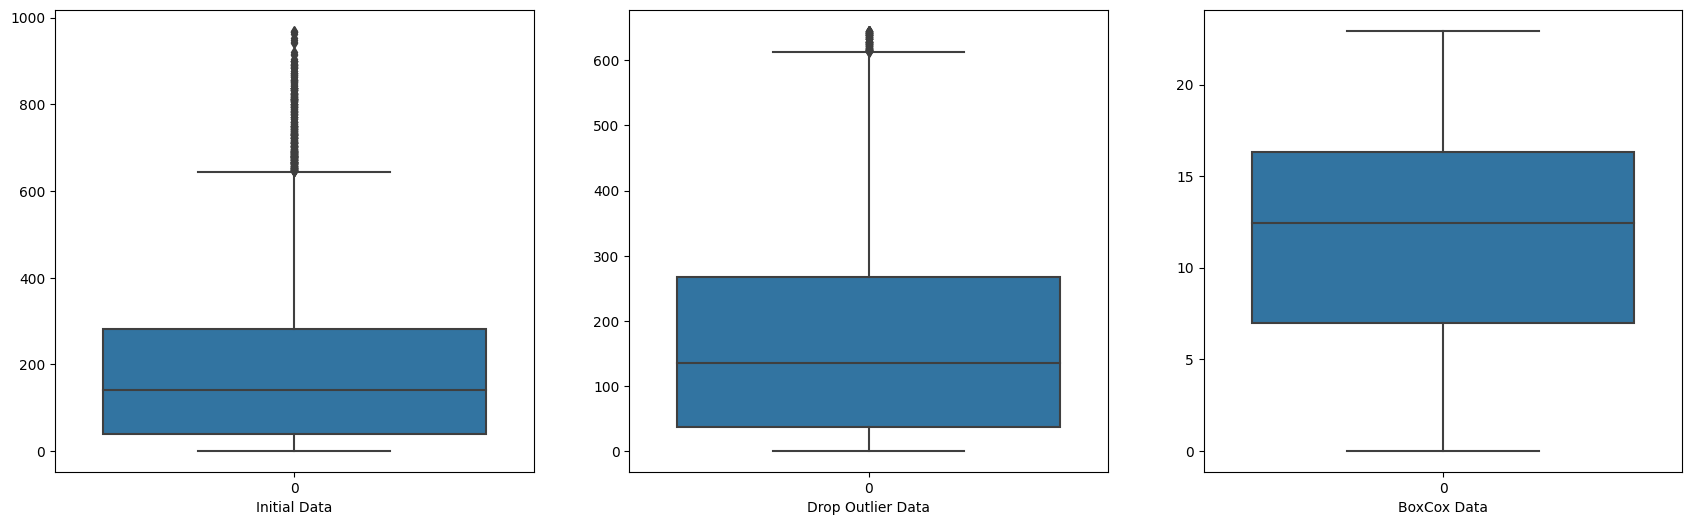

In [27]:
fig, axes = plt.subplots(1,3, figsize=(21, 6))
sns.boxplot(df['cnt'], ax=axes[0])
sns.boxplot(df_no_outlier['cnt'],ax=axes[1])
sns.boxplot(bcx, ax=axes[2])

axes[0].set_xlabel('Initial Data')
axes[1].set_xlabel('Drop Outlier Data')
axes[2].set_xlabel('BoxCox Data')

plt.show()

* Dengan melakukan *BoxCox Transformation* dependent variable lebih mendekati bentuk normal distribution.

In [28]:
# Dataframe untuk modeling 

df_model = df_no_outlier.copy()

In [29]:
# Transformed Target

df_model['bcx_cnt'] = bcx

## **Modeling**

In [30]:
df_model.head()

,hum,weathersit,holiday,season,temp,hr,cnt,day,timeofday,bcx_cnt
0,0.62,1,0,4,0.36,16,250,4,2,15.911504
1,0.64,1,0,2,0.54,4,18,6,4,4.864046
2,0.53,1,0,2,0.62,23,107,2,4,11.249729
3,0.87,2,0,2,0.36,8,145,5,1,12.769756
5,0.72,1,0,4,0.46,0,45,0,4,7.674623


**Data Splitting**

In [31]:
# Data splitting

x = df_model.drop(['cnt', 'bcx_cnt'], axis=1)
y = df_model['bcx_cnt']

In [32]:
print(x.shape , y.shape)

(11827, 8) (11827,)


In [33]:
# Train and Test Splitting

x_train, x_test, y_train, y_test = train_test_split(
                                    x,
                                    y,
                                    test_size = 0.2,
                                    random_state=1                                     
)

In [34]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape )

(9461, 8) (2366, 8)
(9461,) (2366,)


**Encoding**

In [35]:
# Encoding

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['weathersit','season', 'timeofday', 'day'])
], remainder='passthrough')

**Model Selection**

In [36]:
# Algoritma yang digunakan

lr = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
ada = AdaBoostRegressor()
gb = GradientBoostingRegressor()

# Using Power Transformer 
# pt = PowerTransformer(method='box-cox')

# bcx_knn = TransformedTargetRegressor(knn,transformer=pt)
# bcx_rf = TransformedTargetRegressor(rf, transformer=pt)
# bcx_xgb = TransformedTargetRegressor(xgb, transformer=pt)
# bcx_ada = TransformedTargetRegressor(ada, transformer=pt)
# bcx_gb = TransformedTargetRegressor(gb,transformer=pt)

# model = [lr, bcx_knn, bcx_rf, bcx_xgb, bcx_ada, bcx_gb]

model = [lr, knn, rf, xgb, ada, gb]

# Estimator
estimator = Pipeline([
            ('preprocess', ct),
            ('reg', model)
])

hyperparam_space = [{'reg': model}]

# Cross Validation
kfold = KFold(n_splits=5, shuffle=True)

**Model Selection Score Result**

In [37]:
scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

cv_result = []

for i in scoring:

    search = GridSearchCV(
        estimator, # model to tune
        param_grid = hyperparam_space, # hyperparameter space
        cv = kfold, # evaluation method
        scoring = i, # metrics
        n_jobs = -1 # use all cores
    )   

    search.fit(x_train,y_train)

    cv_result.append(search.cv_results_)

In [38]:
rmse = pd.DataFrame(cv_result[0])

rmse[['param_reg', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,param_reg,mean_test_score,std_test_score,rank_test_score
3,"XGBRegressor(base_score=None, booster=None, ca...",-1.760659,0.033867,1
2,RandomForestRegressor(),-1.913488,0.030270,2
1,KNeighborsRegressor(),-2.251085,0.073343,3
5,GradientBoostingRegressor(),-2.372568,0.024199,4
4,AdaBoostRegressor(),-3.096481,0.054322,5
0,LinearRegression(),-3.574187,0.047517,6


In [39]:
mae = pd.DataFrame(cv_result[1])

mae = mae[['param_reg', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
mae

,param_reg,mean_test_score,std_test_score,rank_test_score
3,"XGBRegressor(base_score=None, booster=None, ca...",-1.364916,0.025577,1
2,RandomForestRegressor(),-1.456767,0.020802,2
1,KNeighborsRegressor(),-1.721552,0.019745,3
5,GradientBoostingRegressor(),-1.826608,0.036853,4
4,AdaBoostRegressor(),-2.558467,0.046475,5
0,LinearRegression(),-2.834405,0.052168,6


In [40]:
mape = pd.DataFrame(cv_result[2])

mape[['param_reg', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,param_reg,mean_test_score,std_test_score,rank_test_score
3,"XGBRegressor(base_score=None, booster=None, ca...",-5.662444e+13,1.315541e+13,1
2,RandomForestRegressor(),-6.321998e+13,1.805218e+13,2
1,KNeighborsRegressor(),-6.779135e+13,2.072284e+13,3
5,GradientBoostingRegressor(),-8.778930e+13,2.665565e+13,4
0,LinearRegression(),-1.464662e+14,3.820262e+13,5
4,AdaBoostRegressor(),-1.687583e+14,3.941068e+13,6


* Berdasarkan model selection diatas didapatkan hasil scoring dengan metode RMSE, MAE, dan MAPE ketiganya memberikan hasil XGBRegressor sebagai algoritma yang memiliki score tertinggi dan RandomForestRegressor di posisi kedua.
* Selanjutnya kita akan melakukan perdiksi menggunakan test set memakai XGBRegressor dan GradientBoostingRegressor.

**Using Selected Model On Test Set**

In [41]:
model =  {
    'RFR': rf,
    'XGB': xgb
}

In [42]:
score_rmse = []
score_mae = []
score_mape = []

In [43]:
# Inverse data BoxCox untuk mempermudah interpretaasi
y_test_inv = inv_boxcox(y_test, lam)

for i in model:

   models = Pipeline([
      ('preprocessing', ct),
      ('model', model[i])
   ])

   models.fit(x_train,y_train)
   y_pred = models.predict(x_test)

   # Inverse data BoxCox untuk mempermudah interpretaasi
   y_pred_inv = inv_boxcox(y_pred, lam)
  

   score_rmse.append(np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
   score_mae.append(mean_absolute_error(y_test_inv, y_pred_inv))
   score_mape.append(mean_absolute_percentage_error(y_test_inv, y_pred_inv))

In [44]:
score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=model.keys())

score_before_tuning

,RMSE,MAE,MAPE
RFR,63.201658,42.206911,0.392571
XGB,58.992938,39.518632,0.365266


* Berdasarkan nilai skor diatas XGB memiliki nilai yang lebih baik dibandingkan RFR di RMSE dan MAEE skor.
* RFR memiliki nilai skor yang lebih baik di MAPE.
* Oleh karena itu, kita akan menggunakan XGB sebagai final model.

## **Hyperparameter Tuning**

Setelah kita dapatkan XGBRegressor sebagai model terbaik, selanjutnya akan dilakukan Hyperparameter Tuning terhadap XGBRegressor.   

In [45]:
xgb =XGBRegressor()

estimator_xgb_tree = Pipeline([
            ('preprocess', ct),
            ('model', xgb)
])


# Learning rate
eta = list(np.arange(1, 55, 5)/100)

# Gamma (min_impurity_decrease)
gamma = list(np.arange(0, 11)) # Semakin besar nilainya, semakin konservatif/simpel modelnya

# Kedalaman pohon
max_depth = list(np.arange(3, 13))

# Jumlah pohon
n_estimators = [100, 150, 200, 250, 500]

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(0, 11)/10)

# Jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(0, 10)/10)

# Lambda (Regulariztion)
reg_lambda = list(np.arange(1,6))

# Alpha (regularization)
reg_alpha = list(np.arange(0, 100 , 2)/1000) # Semakin besar nilainya, semakin konservatif/simpel modelnya

hyperparam_space_xgb_tree =[{
    'model__eta': eta,
    'model__gamma': gamma,
    'model__max_depth': max_depth,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample, 
    'model__colsample_bytree': colsample_bytree,
    'model__reg_lambda': reg_lambda,    
    'model__reg_alpha': reg_alpha
}]


In [46]:
search_xgb_tree = RandomizedSearchCV(
    estimator_xgb_tree, # model to tune
    param_distributions= hyperparam_space_xgb_tree, # hyperparameter space
    cv = kfold, # evaluation method
    scoring = 'neg_mean_absolute_error',
    n_iter = 100,
    random_state = 1,
    n_jobs = -1 # use all cores
)   

In [47]:
search_xgb_tree.fit(x_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['weathersit',
                                                                                'season',
                                                                                'timeofday',
                                                                                'day'])])),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_byn...
                                                                 250, 500],
                                         'model__reg_alpha': [0.0, 0.002, 0.004,
                                                              0.006, 0.008,
                                                              0.01, 0.012,
                                                              0.014, 0.016,
                                                              0.018, 0.02,
                                                              0.022, 0.024,
                                                              0.026, 0.028,
                                                              0.03, 0.032,
                                                              0.034, 0.036,
                                                              0.038, 0.04,
                                                              0.042, 0.044,
                                                              0.046, 0.048,
                                                              0.05, 0.052,
                                                              0.054, 0.056,
                                                              0.058, ...],
                                         'model__reg_lambda': [1, 2, 3, 4, 5],
                                         'model__subsample': [0.0, 0.1, 0.2,
                                                              0.3, 0.4, 0.5,
                                                              0.6, 0.7, 0.8,
                                                              0.9, 1.0]}],
                   random_state=1, scoring='neg_mean_absolute_error')

In [48]:
best_params = search_xgb_tree.best_params_

best_params

{'model__subsample': 1.0,
 'model__reg_lambda': 2,
 'model__reg_alpha': 0.042,
 'model__n_estimators': 500,
 'model__max_depth': 6,
 'model__gamma': 1,
 'model__eta': 0.11,
 'model__colsample_bytree': 0.8}

In [49]:
print(f'Best MAE Score : {-(search_xgb_tree.best_score_)}')

Best MAE Score : 1.3382119205039382


**Using Selected Parameter On Test Set**

In [50]:
model = XGBRegressor(max_depth = best_params['model__max_depth'],
                    gamma = best_params['model__gamma'], 
                    eta = best_params['model__eta'],
                    n_estimators = best_params['model__n_estimators'],
                    reg_lambda = best_params['model__reg_lambda'], 
                    reg_alpha = best_params['model__reg_alpha'], 
                    subsample = best_params['model__subsample'], 
                    colsample_bytree = best_params['model__colsample_bytree'])


In [51]:
score_rmse = []
score_mae = []
score_mape = []

In [52]:
models = Pipeline([
   ('preprocessing', ct),
   ('model', model)
])

models.fit(x_train,y_train)
y_pred = models.predict(x_test)

# Inverse data BoxCox untuk mempermudah interpretaasi
y_pred_inv = inv_boxcox(y_pred, lam)


score_rmse.append(np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
score_mae.append(mean_absolute_error(y_test_inv, y_pred_inv))
score_mape.append(mean_absolute_percentage_error(y_test_inv, y_pred_inv))

In [53]:
score_after_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=['XGB'])

score_after_tuning

,RMSE,MAE,MAPE
XGB,58.475786,39.141647,0.356662


**Peformance Comparison**

In [54]:
# Score before tuning

score_before_tuning.iloc[[1]]

,RMSE,MAE,MAPE
XGB,58.992938,39.518632,0.365266


In [55]:
# Score after tuning

score_after_tuning

,RMSE,MAE,MAPE
XGB,58.475786,39.141647,0.356662


* Terjadi peningkatan yang terhadap model walaupun tidak signifikan. Dikarenakan dalam pemilihan hyperparameter tuning menggunakan RandomizeSearch untuk menghemat waktu, kemungkinan masih ada kombinasi parameter yang lebih baik lagi jika menggunakan GridSearch.

**Check Overfitting**

In [56]:
train_score = -(search_xgb_tree.best_score_)
test_score = mean_absolute_error(y_test, y_pred)

print(f'Score Data Train : {train_score}')
print(f'Score Data Test : {test_score}')

Score Data Train : 1.3382119205039382
Score Data Test : 1.3090780124361576


* Hasil score antara Train dan Test set tidak jauh berbeda, bisa kita simpulkan model tidak mengalami overfitting

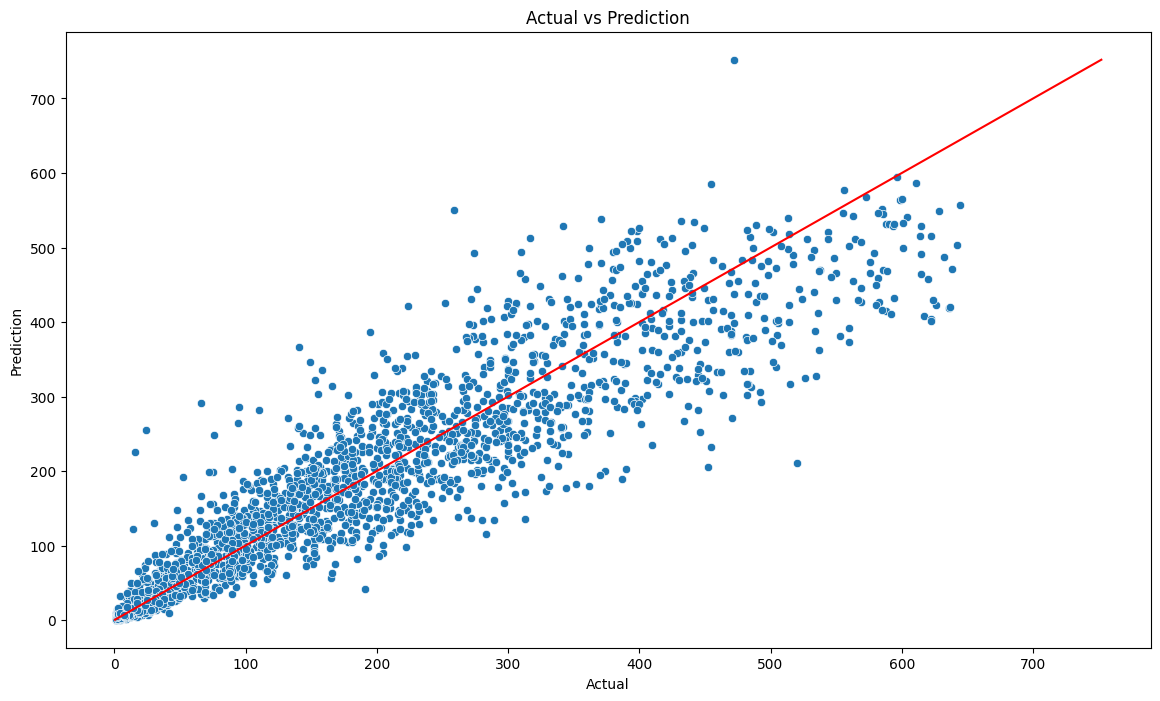

In [57]:
plt.figure(figsize=(14, 8))

sns.scatterplot(x = y_test_inv, y = y_pred_inv)

p1 = max(max(y_pred_inv), max(y_test_inv))
p2 = min(min(y_pred_inv), min(y_test_inv))
plt.plot([p1, p2], [p1, p2], 'r-')

plt.title('Actual vs Prediction')
plt.xlabel('Actual')
plt.ylabel('Prediction')

plt.show()

* Jika dilihat dari grafik actual vs predicted diatas sebagian besar data tersebar di sekitar area *fitted line*. Ini menunjukan model sudah dapat memprediksi dengan cukup baik.
* Akan tetapi dengan nilai MAE = 39.51 dan MAPE = 0.35, masih ada ruang untuk peningkatan peforma pada model. 

**Feature Importances**

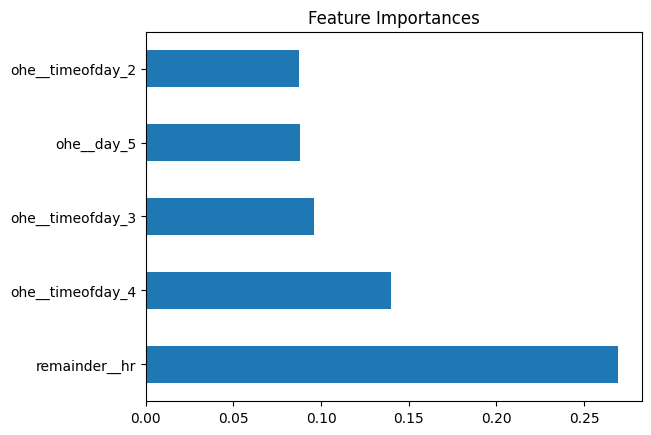

In [58]:
coef = search_xgb_tree.best_estimator_['model'].feature_importances_
feature_name = ct.get_feature_names_out()

feature_imp = pd.Series(coef, feature_name).sort_values(ascending=False).head()

feature_imp.plot(kind='barh', title='Feature Importances');

* Dari grafik diatas feature *hour* menjadi yang paling berpengaruh terhadap target.
* Kemudian diikuti dengan *time of day 2, 3, & 4 (Afternoon, Evening, & Night)* dan juga *day 5(Saturday)*. 

****

## **Conclusion**

Kesimpulan yang bisa diambil, dari proses modeling diatas adalah:

* Dikarenakan target yang tidak memiliki distribusi normal dan memiliki cukup banyak outlier, untuk mendapatkan model dengan peforma yang baik, maka niliai outlier dihilangkan dari data. Serta dikarenakan distribusi target yang memiliki *skewnees* maka dilakukan transformasi dengan metode BoxCox untuk mencapai bentuk yang mendekati distribusi normal. Oleh karena itu hasil prediksi dari model perlu diberikan fungsi *inv_boxcox* untuk dapat menginterpretasi hasil prediksi dengan mudah.

* Feature *hour*, yang dimana menunjukan waktu dalam 24 jam menjadi feature yang paling mempengaruhi nilai dari target. Ini bisa dipahami, bahwa memang pengguna jasa *bike sharing* cenderung memiliki *trend* menggunakan sepeda pada waktu - waktu tertentu saja.

* Batasan atau kemampuan model dalam memprediksi suatu data, terbatas pada rentang 1 sampai dengan 625 unit sepeda. Jika, melebihi dari itu kemungkinan model akan memprediksi dengan error yang lebih tinggi dari yang sudah di *training* diatas dengan MAE = 39.51 dan MAPE = 0.35. Dengan MAPE 0.35, berarti model akan memprediksi suatu data dengan kemungkinan meleset 35 % dari harga seharusnyaa.

* Selain batasan diatas, model ini juga hanya bisa memprediksi di Negara yang memiliki 4 musim saja. Untuk negara-negara tropis tentunya, akan memiliki jumlah musim yang berbeda dan juga temperatur dan *humidity* yang berbedaa.

* Model diatas hanya bisa dipakai, untuk memprediksi pada suatu waktu tertentu saja. Hal ini bisa bermanfaat pada saat memprediksi pada waktu - waktu yang dianggap penting seperti pada hari libur nasional atau pada saat cuaca buruk, sehingga pemilik usaha bisa memperkirakan apakah armada yang tersedia sudah mencukupi atau belum.

****

## **Recommendation**

Rekomendasi yang dapat diberikan adalah:

* Pada proses Hyperparameter Tuning, bisa menggunakan GridSearchCV untuk menemukan hasil peforma yang lebih baik pada model. Pada Notebook ini hanya menggunakan RandomizeSearch untuk menghemat waktu pada proses tuning.

* Untuk meningkatkan peforma model, feature baru juga bisa ditambahkan. Salah satunya adalah indeks kualitas udara atau indeks kepadatan lalu-lintas. Selain itu, penambahan jumlah data juga dapat membantu meningkat peforma pada model.

* Untuk dapat melihat trend dari jumlah armada sepeda yang dibutuhkan, Timeseries Forecasting bisa dilakukan terhadap data. Kelemahan dari model diatas adalah hanya dapat memprediksi pada satu waktu tertentu saja. Sedangkan, dengan menggunakan Timeseries Forecasting pengusaha dapat melihat kebutuhan armada sepeda dalam beberapa waktu ke depan. Hal ini tentu sangat memudahkan bagi pengusaha untuk melakukan *planning* dari data *Forecasting*.

* Pengusaha juga bisa melakukan Machine Learning - Classification, terhadap pengguna jasa sepeda. Untuk melihat apakah pengguna tersebut *registered* atau *casual* user. Dengan mengumpulkan data mengenai user, nantinya pengusaha bisa mengetahui apa saja yang mempengaruhi user tersebut menjadi *registered user* atau tidak.



****

In [60]:
# Save model

final_model = XGBRegressor(subsample = 1,
                           reg_lambda = 2,
                           reg_alpha = 0.042,
                           n_estimators = 500,
                           max_depth = 6,
                           gamma = 1,
                           eta = 0.11,
                           colsample_bytree = 0.8
)

import pickle

estimator = Pipeline([('preprocess', ct) , ('model', final_model)])

estimator.fit(x_train, y_train)

pickle.dump(estimator, open('XGB-1-regression.pkl', 'wb'))

****

In [61]:
# Load model

loaded_model = pickle.load(open('XGB-1-regression.pkl', 'rb'))

In [68]:
print(f'Nilai Lambda dari BoxCox: {lam}')

Nilai Lambda dari BoxCox: 0.33355718858939065


In [75]:
# Prediksi

# Gunakan inverse boxcox untuk mendapatkan angka yang sesuai.
predicted = (inv_boxcox(loaded_model.predict(x_train), lam))

pd.DataFrame(predicted)

,0
0,357.403351
1,237.779282
2,442.331787
3,3.856879
4,106.254715
...,...
9456,505.209900
9457,322.471313
9458,69.200500
9459,56.452831
